In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import csv
from scipy.interpolate import interp1d

In [2]:
np.random.seed(99)

In [3]:
# load data

with open("./data/ENSO.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    X = [row for row in reader][1:]
    X = np.array([list(map(float, row)) for row in X])
    
data_length = X.shape[0]
x = np.linspace(0, data_length - 1, data_length)
int_mul = 10
x_new = np.linspace(0, data_length - 1, data_length * int_mul)

Nino12 = 0
Nino3 = 1
Nino34 = 2
Nino4 = 3

variables = np.array(['Nino 1+2','Nino 3','Nino 3.4','Nino 4'])


seq = [Nino12, Nino3, Nino34, Nino4]
N_nodes = len(seq)
X_new = np.zeros((data_length * int_mul, len(seq)))
i = 0
for item in seq:
    tmp = np.array(X[:,item])
    f = interp1d(x, tmp, kind = 'cubic')
    arr = f(x_new)
    
    X_new[:,i] = arr.T
    i += 1

X = X_new
    
q1 = np.percentile(X, 25, interpolation='midpoint', axis=0)
q2 = np.percentile(X, 50, interpolation='midpoint', axis=0)
q3 = np.percentile(X, 75, interpolation='midpoint', axis=0)

X = (X - q2)/(q3 - q1)

print(X.shape)

N_washout = 50 * int_mul
N_train = 1700 * int_mul
N_tstart = 50 * int_mul
N_test = 1700 * int_mul

X_washout = X[:N_washout]

X_t = X[N_washout:N_washout+N_train-1]
Y_t = X[N_washout+1:N_washout+N_train]

X_test = X[N_tstart:N_tstart + N_test]

(18360, 4)


In [4]:
N_dim = N_nodes # dimension of inputs (and outputs)
N_units = 250*N_dim #units in the reservoir 

In [5]:
%run ./ESN.ipynb
%run ./Reconstruct.ipynb

N_net = 25
TDInet = []

N_rep, N_evo = 20, 5

for net in range(N_net):
    esn = ESN(N_units, N_dim, N_dim)
    esn.train(X_washout, X_t, Y_t)
    
    TDInet.append(cal_TDI(esn, X_test, N_nodes, 1, 0, 0, N_rep, N_washout, N_evo))

TDI = np.mean(np.array(TDInet), axis=0)

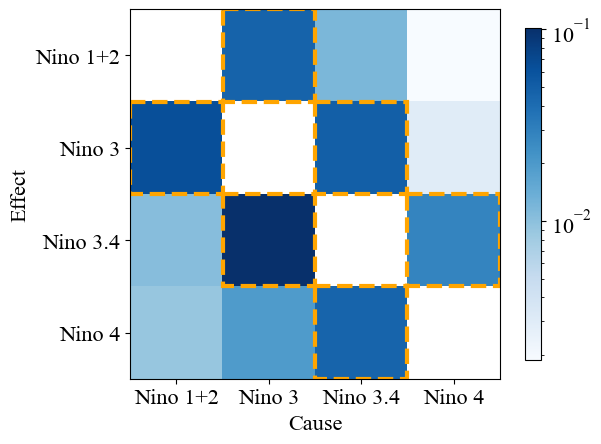

In [6]:
%run ./Plot_TDI.ipynb
plot_TDI_rw(TDI, 'ENSO', variables, seq, 0.02)